In [64]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

# Preprocessing and evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

# Model building
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

# Graphs and charts
import plotly.express as px
from plotly.subplots import make_subplots

In [65]:
df = pd.read_csv('./data/Realisasi Pendapatan Negara, 2007-2009.csv')
df2 = pd.read_csv('./data/Realisasi Pendapatan Negara, 2010-2012.csv')
df3 = pd.read_csv('./data/Realisasi Pendapatan Negara, 2013-2015.csv')
df4 = pd.read_csv('./data/Realisasi Pendapatan Negara, 2016-2018.csv')
df5 = pd.read_csv('./data/Realisasi Pendapatan Negara, 2019-2021.csv')
df6 = pd.read_csv('./data/Realisasi Pendapatan Negara, 2022-2024.csv')

In [66]:
df.head()

,Sumber Penerimaan - Keuangan,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,Realisasi Pendapatan Negara (Milyar Rupiah),NaN,NaN
1,NaN,2007,2008.0,2009.0
2,I. Penerimaan,706108,979305.0,847096.0
3,Penerimaan Perpajakan,490988,658701.0,619922.0
4,Pajak Dalam Negeri,470052,622359.0,601252.0


In [67]:
df2.head()

,Sumber Penerimaan - Keuangan,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,Realisasi Pendapatan Negara (Milyar Rupiah),NaN,NaN
1,NaN,2010,2011.0,2012.0
2,I. Penerimaan,992249,1205346.0,1332322.9
3,Penerimaan Perpajakan,723307,873874.0,980518.1
4,Pajak Dalam Negeri,694392,819752.0,930861.8


In [68]:
penerimaan_pajak = df[df.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df = pd.DataFrame({
    'Year': ['2007', '2008', '2009'],
    'Penerimaan Pajak': penerimaan_pajak.values.flatten()
})
cleaned_df.head()

,Year,Penerimaan Pajak
0,2007,490988
1,2008,658701.0
2,2009,619922.0


In [69]:
penerimaan_pajak2 = df2[df2.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df2 = pd.DataFrame({
    'Year': ['2010', '2011', '2012'],
    'Penerimaan Pajak': penerimaan_pajak2.values.flatten()
})

penerimaan_pajak3 = df3[df3.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df3 = pd.DataFrame({
    'Year': ['2013', '2014', '2015'],
    'Penerimaan Pajak': penerimaan_pajak3.values.flatten()
})

penerimaan_pajak4 = df4[df4.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df4 = pd.DataFrame({
    'Year': ['2016', '2017', '2018'],
    'Penerimaan Pajak': penerimaan_pajak4.values.flatten()
})

penerimaan_pajak5 = df5[df5.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df5 = pd.DataFrame({
    'Year': ['2019', '2020', '2021'],
    'Penerimaan Pajak': penerimaan_pajak5.values.flatten()
})

penerimaan_pajak6 = df6[df6.iloc[:, 0].str.strip() == 'Penerimaan Perpajakan'].iloc[:, 1:4]
cleaned_df6 = pd.DataFrame({
    'Year': ['2022', '2023', '2024'],
    'Penerimaan Pajak': penerimaan_pajak6.values.flatten()
})

In [70]:
df_grouped = pd.concat([cleaned_df, cleaned_df2, cleaned_df3, cleaned_df4, cleaned_df5, cleaned_df6], axis=0).reset_index(drop=True)
print(df_grouped)

    Year Penerimaan Pajak
0   2007           490988
1   2008         658701.0
2   2009         619922.0
3   2010           723307
4   2011         873874.0
5   2012         980518.1
6   2013        1077306.7
7   2014        1146865.8
8   2015       1240418.86
9   2016        1284970.1
10  2017        1343529.8
11  2018        1518789.8
12  2019        1546141.9
13  2020       1285136.32
14  2021        1547841.1
15  2022        2034552.5
16  2023        2118348.0
17  2024        2309859.8


In [71]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_grouped['Penerimaan Pajak'] = scaler.fit_transform(df_grouped[['Penerimaan Pajak']])
df_grouped

,Year,Penerimaan Pajak
0,2007,0.000000
1,2008,0.092207
2,2009,0.070887
3,2010,0.127727
4,2011,0.210507
5,2012,0.269139
6,2013,0.322353
7,2014,0.360596
8,2015,0.412031
9,2016,0.436524


In [ ]:
data = df_grouped['Penerimaan Pajak'].values
X, y = [], []
timesteps = 3  # Menetapkan timesteps

for i in range(len(data) - timesteps):
    X.append(data[i:i+timesteps])
    y.append(data[i+timesteps])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Mengubah bentuk menjadi 3D untuk LSTM

# Membagi data menjadi 80% data latih, 10% data validasi, dan 10% data uji
train_size = int(0.8 * len(X))
val_size = int(0.2 * len(X))
test_size = int(0.2 * len(X))

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# Menampilkan ukuran data latih, validasi, dan uji
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("X_val: ", X_val.shape)


X_train:  (9, 6, 1)
X_test:  (1, 6, 1)
X_val:  (2, 6, 1)


In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # The LSTM layer
model.add(LSTM(50, return_sequences=True,)) # The LSTM layer

# Anda dapat menambahkan lebih banyak layer sesuai kebutuhan, tetapi perhatikan overfitting

model.add(Dropout(0.1))  # Layer dropout untuk mengurangi overfitting

model.add(Dense(25))  # Lapisan Dense dengan 25 neuron
model.add(Dense(1))  # Lapisan Dense untuk output

model.compile(loss="mean_squared_error", optimizer="adam")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [108]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.0145 - val_loss: 0.1575
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.0148 - val_loss: 0.1581
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.0145 - val_loss: 0.1590
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.0141 - val_loss: 0.1602
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0139 - val_loss: 0.1616
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.0136 - val_loss: 0.1632
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0132 - val_loss: 0.1648
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0128 - val_loss: 0.1664
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.0126 - val_loss: 0.1680
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0122 - val_loss: 0.1694
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0123 - val_loss: 0.1706
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.0121 - val_lo

In [105]:
loss = model.evaluate(X_test, y_test)
print("Loss pada Data Uji:", loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2615
Loss pada Data Uji: 0.26153525710105896


In [109]:
input_data = data[-timesteps:].reshape(1, timesteps, 1)  # Data input terakhir
prediksi_2030 = model.predict(input_data)

# Reshape prediksi_2030 to 2D before applying inverse_transform
prediksi_2030 = prediksi_2030.reshape(-1, 1)  # Reshape to (samples, 1)

prediksi_2030 = scaler.inverse_transform(prediksi_2030)  # Mengembalikan ke skala asli

# If you need the original shape, reshape it back
prediksi_2030 = prediksi_2030.reshape(1, timesteps, 1)

print("Prediksi Penerimaan pada Tahun 2030:", prediksi_2030[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediksi Penerimaan pada Tahun 2030: [1253758.5]


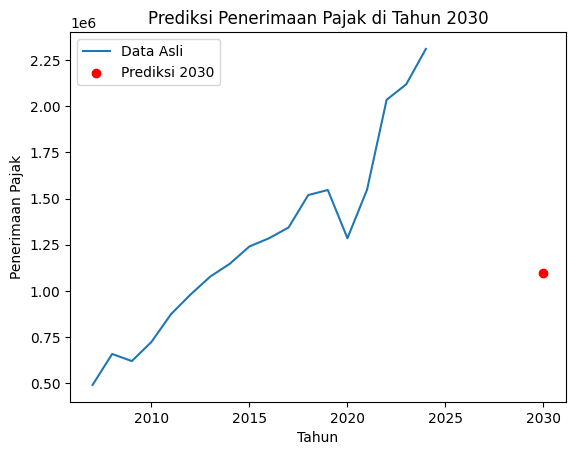

In [107]:

# Assuming 'prediksi_2030' is a 3D array with shape (1, timesteps, 1)
# and you want to plot the first predicted value against 2030
plt.plot(df_grouped['Year'], scaler.inverse_transform(df_grouped[['Penerimaan Pajak']]), label="Data Asli")

# Extract the first predicted value from prediksi_2030
prediksi_value = prediksi_2030[0][0][0]  # Access the value

plt.scatter(2030, prediksi_value, color='red', label="Prediksi 2030")  # Plot single point
plt.title("Prediksi Penerimaan Pajak di Tahun 2030")
plt.xlabel("Tahun")
plt.ylabel("Penerimaan Pajak")
plt.legend()
plt.show()